In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import treescope
treescope.basic_interactive_setup(autovisualize_arrays=True)
# Define the model as provided
class SimpleMLP(nn.Module):
    hidden_dim: int = 128
    output_dim: int = 10  # 10 classes for MNIST

    @nn.compact
    def __call__(self, x):
        # x is expected to be of shape (batch, 784)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

# Instantiate the model and initialize parameters
model = SimpleMLP()
x = jnp.ones((1, 784))  # dummy input for tracing
key = jax.random.PRNGKey(0)
params = model.init(key, x)

# Trace the forward pass
print("JAXPR for the forward pass:")
jaxpr = jax.make_jaxpr(lambda params, x: model.apply(params, x))
print(jaxpr(params, x))


JAXPR for the forward pass:
{ lambda ; a:f32[128] b:f32[784,128] c:f32[10] d:f32[128,10] e:f32[1,784]. let
    f:f32[1,128] = dot_general[dimension_numbers=(([1], [0]), ([], []))] e b
    g:f32[1,128] = reshape[dimensions=None new_sizes=(1, 128) sharding=None] a
    h:f32[1,128] = add f g
    i:f32[1,128] = custom_jvp_call[
      call_jaxpr={ lambda ; j:f32[1,128]. let
          k:f32[1,128] = pjit[
            name=relu
            jaxpr={ lambda ; l:f32[1,128]. let
                m:f32[1,128] = max l 0.0
              in (m,) }
          ] j
        in (k,) }
      jvp_jaxpr_thunk=<function _memoize.<locals>.memoized at 0x7f228c2be480>
      num_consts=0
      symbolic_zeros=False
    ] h
    n:f32[1,10] = dot_general[dimension_numbers=(([1], [0]), ([], []))] i d
    o:f32[1,10] = reshape[dimensions=None new_sizes=(1, 10) sharding=None] c
    p:f32[1,10] = add n o
  in (p,) }


In [2]:
# Define a simple loss function (mean squared error)
def loss_fn(params, x, target):
    predictions = model.apply(params, x)
    loss = jnp.mean((predictions - target) ** 2)
    return loss

# Create a dummy target (e.g., zeros)
target = jnp.zeros((1, 10))

# Compute gradients with respect to parameters
grad_fn = jax.grad(loss_fn)
grads = grad_fn(params, x, target)

print("Computed gradients:")
print(grads)


Computed gradients:
{'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        ,  0.02613581,  0.        , -0.07247249,
        0.        ,  0.0150489 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06783199,  0.        ,  0.        ,  0.00655695,
        0.        ,  0.03450358,  0.        ,  0.01702958,  0.        ,
        0.        ,  0.05186963,  0.        ,  0.02782674,  0.        ,
        0.        ,  0.        ,  0.0604132 ,  0.        ,  0.0154777 ,
        0.00474977, -0.06520472, -0.03093642,  0.        ,  0.        ,
        0.        ,  0.04452242,  0.        , -0.00331485,  0.        ,
        0.00173663,  0.01289283,  0.        ,  0.        ,  0.        ,
        0.06529399,  0.08631974,  0.00370121, -0.03958577,  0.04735618,
        0.0244289 ,  0.        ,  0.        ,  0.03841081,  0.01368353,
        0.        ,  0.        ,  0.        ,  0.        , -0.03650308,
        0.        ,  0.0416798 , -0.01168905,  0.        ,  0.01305666,
       -0.01

In [3]:
import jax
import jax.numpy as jnp
from penzai import pz

@pz.pytree_dataclass(has_implicitly_inherited_fields=True)
class SimpleMLP(pz.nn.Sequential):
    @classmethod
    def from_config(
        cls,
        name: str,
        init_base_rng: jax.Array | None,
        hidden_dim: int = 128,
        output_dim: int = 10,
    ) -> "SimpleMLP":
        # Build the MLP as a sequence of layers:
        return cls([
            # First linear layer: expects an input with 784 features
            pz.nn.Linear.from_config(
                name=f"{name}/Dense1",
                init_base_rng=init_base_rng,
                input_axes={"features": 784},
                output_axes={"features": hidden_dim},
            ),
            # ReLU activation wrapped as an elementwise layer
            pz.nn.Elementwise(jax.nn.relu),
            # Second linear layer: from hidden_dim to output_dim features
            pz.nn.Linear.from_config(
                name=f"{name}/Dense2",
                init_base_rng=init_base_rng,
                input_axes={"features": hidden_dim},
                output_axes={"features": output_dim},
            ),
        ])

    def __call__(self, x: jax.Array, **side_inputs) -> jax.Array:
        return super().__call__(x, **side_inputs)

# ------------------------------------------------------------------------------
# Usage Example:
# ------------------------------------------------------------------------------

# Create a PRNG key:
rng = jax.random.PRNGKey(0)

# Initialize the model:
mlp = SimpleMLP.from_config(name="mlp", init_base_rng=rng)

# Create a dummy input:
# Start with a JAX array of shape (32, 784)
# Then wrap it as a NamedArray with two axes:
#   - axis 0 ("batch"): size 32 (will be vectorized automatically)
#   - axis 1 ("features"): size 784 (matches the linear layer expectation)
dummy_input = pz.nx.wrap(jnp.ones((32, 784))).tag("batch", "features")

# Forward pass:
logits = mlp(dummy_input)

# The resulting NamedArray should have a named shape {'batch': 32, 'features': 10}
print("Output named shape:", logits.named_shape)


Output named shape: {'batch': 32, 'features': 10}


Path to dataset files: /home/j/.cache/kagglehub/datasets/oddrationale/mnist-in-csv/versions/2
Epoch 0000 - Train Loss: 2.3575, Test Loss: 2.2313
Epoch 0010 - Train Loss: 1.0819, Test Loss: 1.1924
Epoch 0020 - Train Loss: 0.5344, Test Loss: 0.7160
Epoch 0030 - Train Loss: 0.3213, Test Loss: 0.5451
Epoch 0040 - Train Loss: 0.2091, Test Loss: 0.4327
Epoch 0050 - Train Loss: 0.1408, Test Loss: 0.3694
Epoch 0060 - Train Loss: 0.0968, Test Loss: 0.3354
Epoch 0070 - Train Loss: 0.0690, Test Loss: 0.3196
Epoch 0080 - Train Loss: 0.0512, Test Loss: 0.3097
Epoch 0090 - Train Loss: 0.0394, Test Loss: 0.3021
Epoch 0100 - Train Loss: 0.0313, Test Loss: 0.2944
Epoch 0110 - Train Loss: 0.0255, Test Loss: 0.2883
Epoch 0120 - Train Loss: 0.0213, Test Loss: 0.2830
Epoch 0130 - Train Loss: 0.0181, Test Loss: 0.2781
Epoch 0140 - Train Loss: 0.0155, Test Loss: 0.2740
Epoch 0150 - Train Loss: 0.0136, Test Loss: 0.2701
Epoch 0160 - Train Loss: 0.0119, Test Loss: 0.2669
Epoch 0170 - Train Loss: 0.0106, Test L

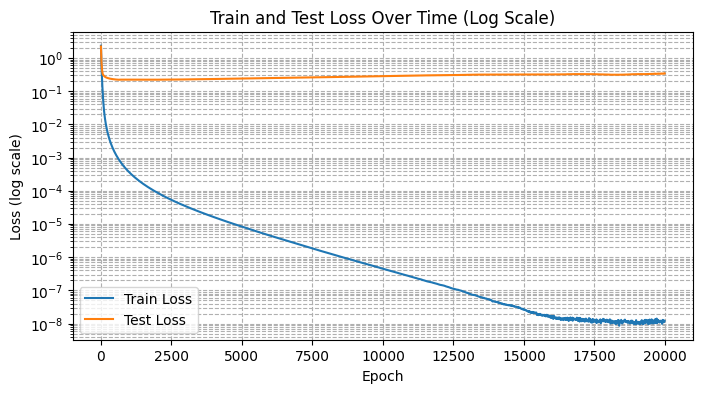

In [4]:
import os
import pandas as pd
import kagglehub
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from penzai import pz
from penzai.toolshed.basic_training import StatefulTrainer

# ------------------------------------------------------------------------------
# Data Loading
# ------------------------------------------------------------------------------

def load_mnist_kagglehub(num_train=500, num_test=50):
    dataset_path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
    print("Path to dataset files:", dataset_path)
    train_csv = os.path.join(dataset_path, "mnist_train.csv")
    test_csv = os.path.join(dataset_path, "mnist_test.csv")
    df_train = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv)
    y_train = df_train["label"].values
    x_train = df_train.drop(columns=["label"]).values
    x_train = x_train.astype("float32") / 255.0
    if "label" in df_test.columns:
        y_test = df_test["label"].values
        x_test = df_test.drop(columns=["label"]).values
    else:
        y_test = None
        x_test = df_test.values
    x_test = x_test.astype("float32") / 255.0
    return (
        jnp.array(x_train[:num_train]),
        jnp.array(y_train[:num_train]),
        jnp.array(x_test[:num_test]),
        jnp.array(y_test[:num_test]) if y_test is not None else None,
    )

# ------------------------------------------------------------------------------
# Model Definition (SimpleMLP)
# ------------------------------------------------------------------------------

@pz.pytree_dataclass(has_implicitly_inherited_fields=True)
class SimpleMLP(pz.nn.Sequential):
    @classmethod
    def from_config(
        cls,
        name: str,
        init_base_rng: jax.Array | None,
        hidden_dim: int = 128,
        output_dim: int = 10,
    ) -> "SimpleMLP":
        return cls([
            pz.nn.Linear.from_config(
                name=f"{name}/Dense1",
                init_base_rng=init_base_rng,
                input_axes={"features": 784},
                output_axes={"features": hidden_dim},
            ),
            pz.nn.Elementwise(jax.nn.relu),
            pz.nn.Linear.from_config(
                name=f"{name}/Dense2",
                init_base_rng=init_base_rng,
                input_axes={"features": hidden_dim},
                output_axes={"features": output_dim},
            ),
        ])

    def __call__(self, x: jax.Array, **side_inputs) -> jax.Array:
        return super().__call__(x, **side_inputs)

# ------------------------------------------------------------------------------
# Loss Function for Training
# ------------------------------------------------------------------------------

def loss_fn(model, state, rng, batch):
    """
    Compute softmax cross-entropy loss for the stateful model on the given batch.
    Returns a tuple (loss, new_loss_fn_state, aux_outputs).
    Here, we return the loss as aux_outputs so that trainer.step() returns it.
    """
    batch_x, batch_y = batch
    x_named = pz.nx.wrap(batch_x).tag("batch", "features")
    logits = model(x_named)
    logits_arr = logits.unwrap("batch", "features")
    one_hot = jax.nn.one_hot(batch_y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits=logits_arr, labels=one_hot).mean()
    return loss, None, loss  # Return loss as aux_outputs

# ------------------------------------------------------------------------------
# Training Setup using StatefulTrainer
# ------------------------------------------------------------------------------

x_train, y_train, x_test, y_test = load_mnist_kagglehub(num_train=500, num_test=50)

# Build NamedArrays for training targets if needed.
# For the images, we tag with ("batch", "features"); for labels, just ("batch").
x_train_named = pz.nx.wrap(x_train).tag("batch", "features")
y_train_named = pz.nx.wrap(y_train).tag("batch")

rng_model = jax.random.PRNGKey(0)
model = SimpleMLP.from_config(name="mlp", init_base_rng=rng_model)

optimizer_def = optax.adam(learning_rate=1e-3)

trainer = StatefulTrainer.build(
    root_rng=rng_model,
    model=model,
    optimizer_def=optimizer_def,
    loss_fn=loss_fn,
    initial_loss_fn_state=None,
    jit=True,
)

# ------------------------------------------------------------------------------
# Training Loop and Loss Recording
# ------------------------------------------------------------------------------

num_epochs = 20000
train_losses = []
test_losses = []
record_interval = 10  # Record losses every 10 epochs

for epoch in range(num_epochs):
    # Training step: we pass a batch tuple (x_train, y_train).
    train_loss = trainer.step(batch=(x_train, y_train))
    
    if epoch % record_interval == 0:
        # Record training loss.
        train_losses.append(train_loss)
        # Compute test loss without updating trainer state.
        # Wrap test inputs and targets:
        x_test_named = pz.nx.wrap(x_test).tag("batch", "features")
        y_test_named = pz.nx.wrap(y_test).tag("batch")
        # Here we simply call loss_fn directly on the current model.
        test_loss, _, _ = loss_fn(trainer.model, None, jax.random.PRNGKey(0), (x_test, y_test))
        test_losses.append(test_loss)
        print(f"Epoch {epoch:04d} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# ------------------------------------------------------------------------------
# Plotting Train and Test Loss
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(0, num_epochs, record_interval), train_losses, label="Train Loss")
plt.plot(range(0, num_epochs, record_interval), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.yscale("log")
plt.title("Train and Test Loss Over Time (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



In [5]:
import jax
import jax.numpy as jnp
from penzai import pz
import optax

# Suppose you have your loss function defined as:
def loss_fn(unbound_model, params, batch, rng):
    # Rebind the unbound model with the current parameters
    rebound_model = pz.bind_variables(unbound_model, params)

    # Wrap the input to match the model's expected named axes
    batch_x, batch_y = batch
    batch_x_named = pz.nx.wrap(batch_x).tag("batch", "features")
    
    # Unwrap the output to get a plain JAX array
    logits = rebound_model(batch_x_named).unwrap("batch", "features")
    one_hot = jax.nn.one_hot(batch_y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()
    return loss


# Assume `model` is an instance of your Penzai model (e.g., SimpleMLP)
# Extract the unbound model and frozen parameters:
unbound_model, params = pz.unbind_params(model, freeze=True)

# Create a dummy batch and PRNG key
batch = (jnp.ones((32, 784)), jnp.zeros((32,), dtype=jnp.int32))  # dummy data
rng = jax.random.PRNGKey(42)

# Compute gradients with respect to the parameters
grads = jax.grad(lambda params: loss_fn(unbound_model, params, batch, rng))(params)


grads




(ParameterValue(
   label='mlp/Dense1.weights',
   value=<NamedArray float32(| features:784, features_out:128) ≈-0.053 ±0.39 [≥-1.1, ≤1.3] zero:14_112 nonzero:86_240 (wrapping jax.Array)
     <Arrayviz rendering>
   | Device: GPU 0>,
   metadata={},
 ),
 ParameterValue(
   label='mlp/Dense2.weights',
   value=<NamedArray float32(| features:128, features_out:10) ≈-1.7e-08 ±1.8e+01 [≥-3.4e+02, ≤3.4e+02] zero:620 nonzero:660 (wrapping jax.Array)
     <Arrayviz rendering>
   | Device: GPU 0>,
   metadata={},
 ))

In [6]:
from jax.flatten_util import ravel_pytree
flat_params, unravel_fn = ravel_pytree(params)

flat_params

print(unravel_fn)

In [7]:

def hidden_activation(flat_params, x):
    """
    Compute a scalar based on the hidden layer activations of the Penzai model.
    
    Parameters
    ----------
    flat_params : jax.Array
        Flattened model parameters.
    x : jax.Array
        Input array (e.g. a MNIST image) with shape (batch, 784).
    
    Returns
    -------
    scalar
        Sum of the activations from the first neuron (over the batch)
        of the hidden layer.
    """
    # Reconstruct the parameter pytree.
    params_tree = unravel_fn(flat_params)
    # Bind parameters to the unbound model.
    rebound_model = pz.bind_variables(unbound_model, params_tree)
    # Wrap the input to match the model's expected named axes.
    x_named = pz.nx.wrap(x).tag("batch", "features")
    
    # Since our model is a Sequential with layers:
    #   [ Dense (Dense1), Elementwise(ReLU), Dense (Dense2) ]
    # we compute the hidden activation by applying the first two layers.
    # (Adjust if your model's structure is different.)
    hidden = rebound_model.layers[0](x_named)  # Dense1: (batch, hidden_dim)
    hidden = rebound_model.layers[1](hidden)     # ReLU activation

    # Unwrap the NamedArray to get a plain JAX array.
    # Here we take the activations for the first neuron across the batch
    # and sum them to yield a scalar (this makes gradient computation straightforward).
    hidden_arr = hidden.unwrap("batch", "features")
    return jnp.sum(hidden_arr[:, 0])

# Flatten the parameters to work with a 1D array.
flat_params, unravel_fn = ravel_pytree(params)


# Select a sample MNIST input; for example, take one example from your dataset:
x_sample = x_test[0:1, :]  # shape (1, 784)

# Define a gradient function for the hidden activation.
grad_hidden_fn = jax.grad(hidden_activation)

# Compute gradients with respect to the flattened parameters.
grads_flat = grad_hidden_fn(flat_params, x_sample)

# Unflatten the gradients back into the original pytree structure.
grads_pytree = unravel_fn(grads_flat)

# For example, inspect the gradient norms for the first dense layer's weights and biases:
first_layer_grads = grads_pytree[0]  # assuming first layer is at index 0
w_grad_norm = jnp.linalg.norm(first_layer_grads['w'])
b_grad_norm = jnp.linalg.norm(first_layer_grads['b'])
print("First layer weight gradient norm:", w_grad_norm)
print("First layer bias gradient norm:", b_grad_norm)


AttributeError: 'SimpleMLP' object has no attribute 'layers'

In [26]:

sample_index = 23  # index of the sample to use
x_sample = x_test[sample_index:sample_index + 1]  # shape (1, 784)
label = y_test[sample_index]  # true label
print("True label:", label)
# First, bind the parameters:
bound_model = pz.bind_variables(unbound_model, params)

# Wrap the input with named axes (here we tag the features axis as "features")
x_named = pz.nx.wrap(x_sample).tag("batch", "features")

# Define a layer that saves its input in a mutable state variable.
@pz.pytree_dataclass
class SaveIntermediate(pz.nn.Layer):
    # We initialize with a state variable (initially None)
    saved: pz.StateVariable = pz.StateVariable(None)
    
    def __call__(self, value, **unused_side_inputs):
        # Save the intermediate value.
        self.saved.value = value
        # Pass the value through unchanged.
        return value

# Create a state variable to hold the hidden activations.
hidden_state = pz.StateVariable(None)


# Insert our SaveIntermediate layer right after it.
patched_model = (
    pz.select(bound_model)
    .at_instances_of(pz.nn.Elementwise)
    .pick_nth_selected(0)  # select the first (and only) Elementwise layer
    .insert_after(SaveIntermediate(hidden_state))
)

# Now run a forward pass with the patched model:
logits = patched_model(x_named)

# The hidden activations are now saved in `hidden_state.value`.
# To get a plain JAX array, we can “unwrap” the NamedArray:
hidden_activations = hidden_state.value.unwrap("batch", "features")

print("Hidden activations shape:", hidden_activations.shape)

patched_model


hidden_activations


print("Predicted label:", jnp.argmax(logits.unwrap("batch", "features")[0]))

logits


True label: 5
Hidden activations shape: (1, 128)
Predicted label: 5


<NamedArray float32(| batch:1, features:10) ≈-5.4e+02 ±9.1 [≥-5.5e+02, ≤-5.2e+02] nonzero:10 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>